In [ ]:
using Revise

using Pkg
Pkg.activate("../")

using Revise
using Plots
using BenchmarkTools
using Downloads
using HDF5
using FastDeDopplerTransform
using CUDA

In [29]:
voyager_url = "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"
h5 = h5open(Downloads.download(voyager_url))
full_spectrogram = h5["data"][:,1,:]
freq_range = range(659935, length=150)
spectrogram = full_spectrogram[freq_range,:]

fch1        = h5["data"]["fch1"][]
t_samp      = h5["data"]["tsamp"][]
f_bin_width = h5["data"]["foff"][] * -1e6

min_drift = 0.0 # Hz/s
max_drift = 1.0 # Hz/s

size(spectrogram)

(150, 16)

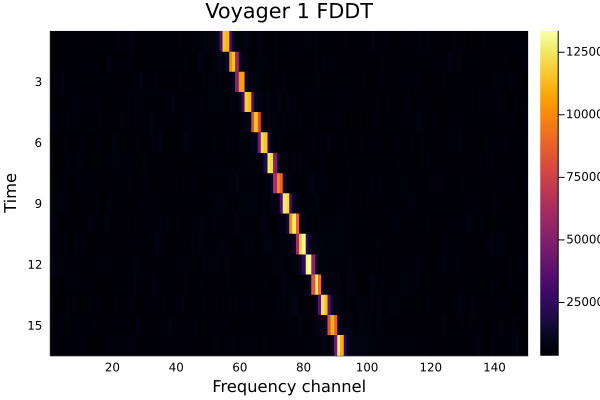

In [30]:
heatmap(spectrogram', 
		title = "Voyager 1 FDDT",
        xlabel = "Frequency channel",
        ylabel = "Time",
		yflip=true)

In [31]:
fddt_small_data = fddt(spectrogram, t_samp, f_bin_width, min_drift, max_drift; use_gpu=true);

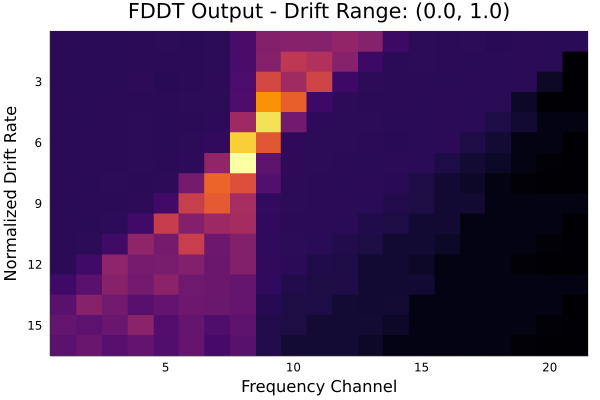

In [32]:
heatmap(fddt_small_data', 
		title = "FDDT Output - Drift Range: ($min_drift, $max_drift)",
        xlabel = "Frequency Channel",
        ylabel = "Normalized Drift Rate",
        legend=false,
        yflip=true)

In [33]:
@benchmark fddt($full_spectrogram, $t_samp, $f_bin_width, $min_drift, $max_drift)

BenchmarkTools.Trial: 32 samples with 1 evaluation.
 Range (min … max):  147.303 ms … 174.793 ms  ┊ GC (min … max):  7.63% … 14.73%
 Time  (median):     162.589 ms               ┊ GC (median):    14.87%
 Time  (mean ± σ):   161.051 ms ±   6.869 ms  ┊ GC (mean ± σ):  13.96% ±  3.28%

       ▃                █ ▃          █▃             ▃            
  ▇▁▁▁▁█▇▁▁▇▇▁▁▁▁▁▁▁▁▁▁▇█▁█▁▇▇▁▁▁▁▇▇▇██▇▇▇▇▁▁▁▁▁▁▇▁▇█▇▁▁▁▁▁▁▁▁▇ ▁
  147 ms           Histogram: frequency by time          175 ms <

 Memory estimate: 237.70 MiB, allocs estimate: 2396637.

In [34]:
@benchmark fddt($full_spectrogram, $t_samp, $f_bin_width, $min_drift, $max_drift; use_gpu=true)

BenchmarkTools.Trial: 380 samples with 1 evaluation.
 Range (min … max):  11.084 ms … 35.128 ms  ┊ GC (min … max): 0.00% …  0.00%
 Time  (median):     12.137 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.169 ms ±  2.800 ms  ┊ GC (mean ± σ):  6.58% ± 10.48%

          █▄                                                   
  ▄▃▃▃▃▅▄▅██▅▄▄▅▃▃▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▃▅▆▃▃▂▃▂▃▂▂▂▂ ▃
  11.1 ms         Histogram: frequency by time        17.6 ms <

 Memory estimate: 27.44 MiB, allocs estimate: 168.

In [35]:
CUDA.reclaim()